In [26]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Part 1 - Quantization

(-0.5, 511.5, 511.5, -0.5)

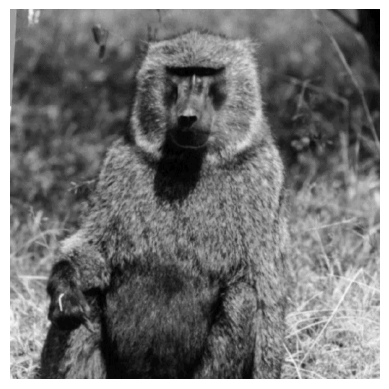

In [64]:
def load_image_as_array(image_path):
    # load the image into numpy array
    with Image.open(image_path) as img:
        img_array = np.array(img)
    return img_array
img_arr = load_image_as_array("monkey.gif").flatten()
plt.imshow(img_arr.reshape(512,512), cmap='grey')
plt.axis('off')

Histogram of the Image pixels

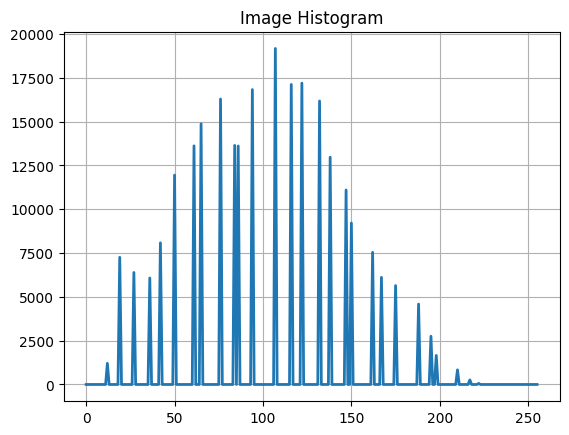

In [28]:
def create_histogram(img_arr):
    hist = np.zeros(256)
    for pixel in img_arr:
        hist[pixel] += 1
    return hist

plt.figure(1)
plt.clf()
plt.title("Image Histogram")

hist = create_histogram(img_arr)
indexes = np.arange(len(hist))

_ = plt.plot(indexes, hist, lw=2)
plt.grid()

Uniform Quantization - 2.a

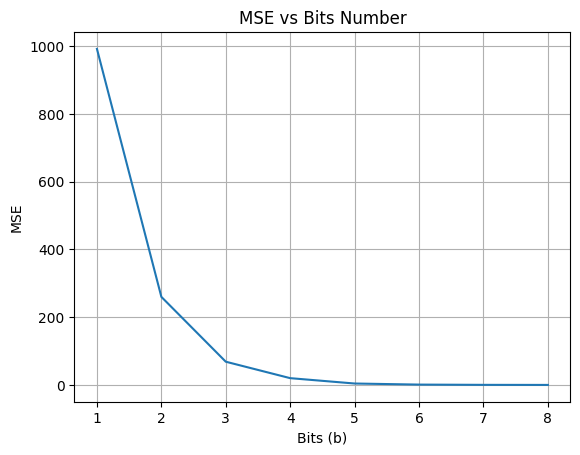

In [49]:
def uniform_quantization(image, b):
    levels = 2**b
    quantization_step = (image.max() - image.min()) / levels
    quantized_image = np.zeros_like(image, dtype=np.uint8)
    interval_entries_array = np.floor((image - image.min())/quantization_step)
    quantized_image = image.min() + (interval_entries_array+0.5)*quantization_step
    mse = np.mean((image - quantized_image)**2)
    return quantized_image, mse

def perform_quantization_for_bits(image, bit_budgets):
    mse_values = np.zeros_like(bit_budgets, dtype=float)
    q_images = []
    # Perform uniform quantization for each bit budget
    for i, b in enumerate(bit_budgets):
        quantized_image, mse = uniform_quantization(image, b)
        q_images.append(quantized_image)
        mse_values[i] = mse
    return mse_values, q_images

bit_budgets = range(1,9)
mse_values, _ = perform_quantization_for_bits(img_arr, bit_budgets)
plt.plot(bit_budgets, mse_values)
plt.title('MSE vs Bits Number')
plt.xlabel('Bits (b)')
plt.ylabel('MSE')
plt.xticks(bit_budgets)
plt.grid(True)

Decision & Representation Levels Plot - 2b

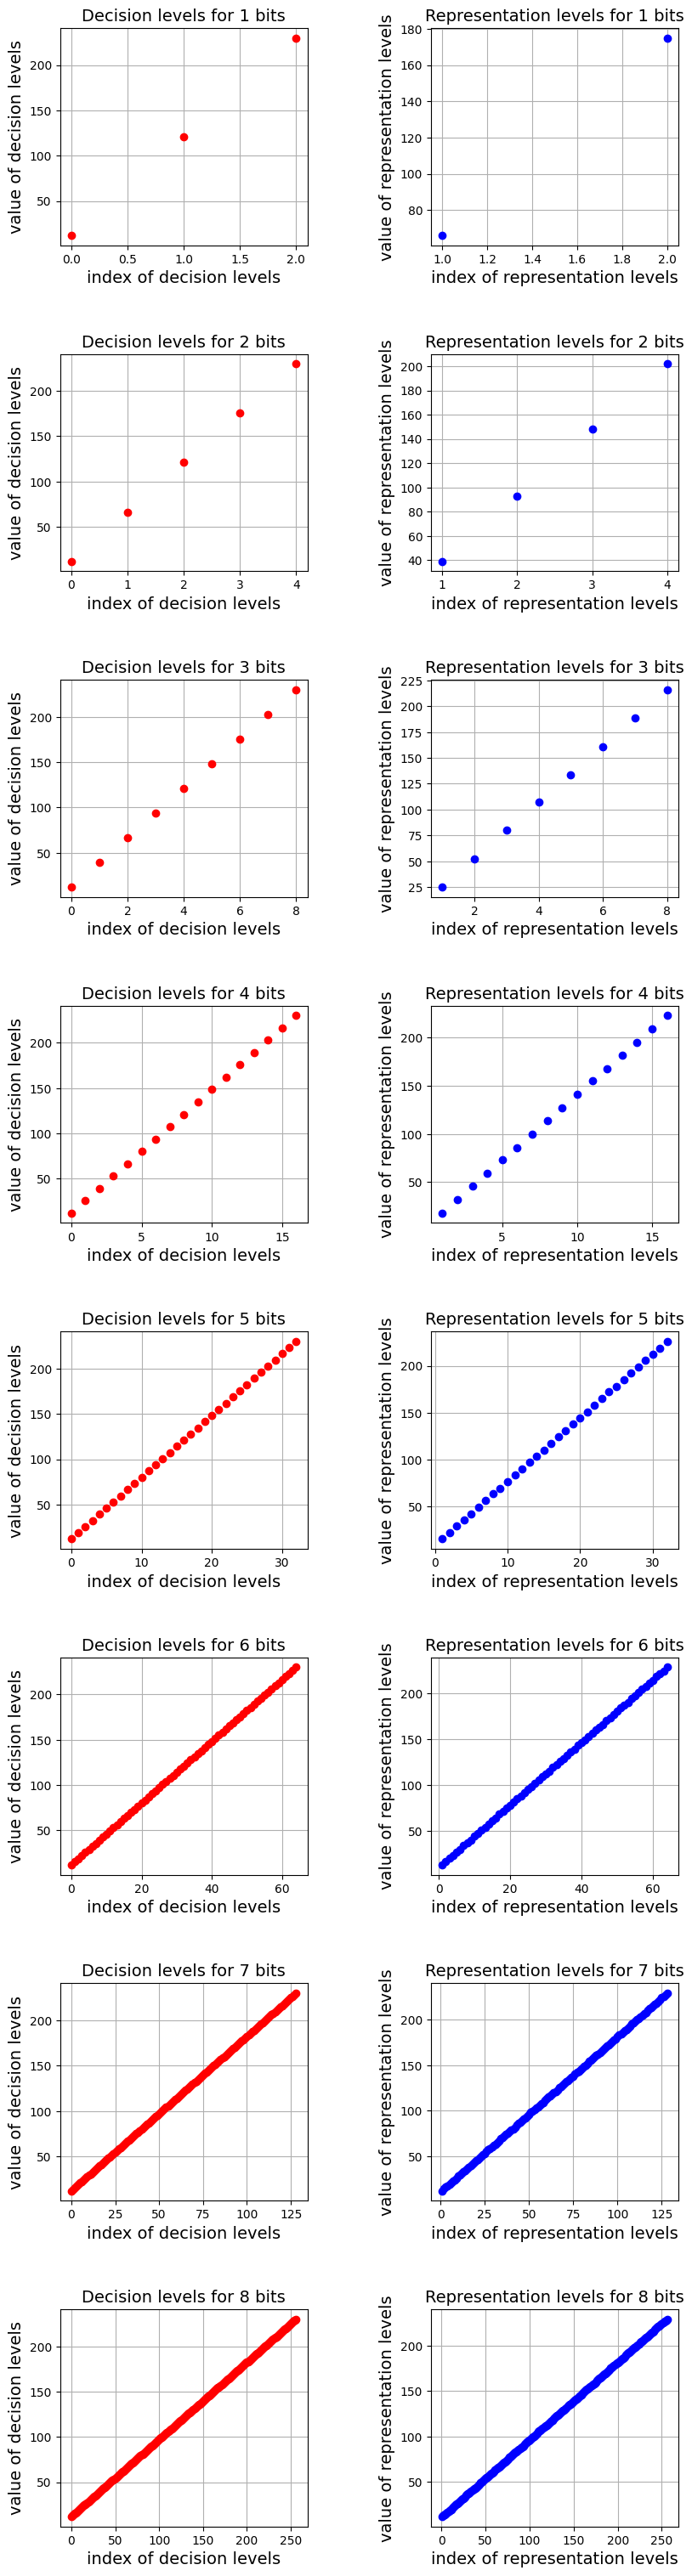

In [30]:
def calculate_uniform_quantization_levels_per_bit(img_arr, b):
  Delta = (img_arr.max() - img_arr.min())/(2**b) # size of single interval
  decision_levels = np.zeros(2**b+1, dtype=np.float64)
  repr_levels = np.zeros(2**b, dtype=np.uint)

  # calculate each array values according to the lecture:
  for i in range(0, 2**b+1) :
    decision_levels[i] = img_arr.min() + i*Delta

  for i in range(0, 2**b) :
    repr_levels[i] = img_arr.min() + (i+0.5)*Delta

  return decision_levels, repr_levels

# set up plot size (8 bits by 2 images (decision and representation))
fig, ax = plt.subplots(8, 2, figsize=(8, 30))
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for b in bit_budgets:
    # calculate decision and representation levels for each bit limitation
    decision_levels, repr_levels = calculate_uniform_quantization_levels_per_bit(img_arr, b)

    # plot the decision levels
    ax[b-1,0].plot(range(0,(2**b)+1), decision_levels, "ro")
    ax[b-1,0].set_title("Decision levels for " + str(b) + " bits" , fontsize = 14)
    ax[b-1,0].set_xlabel("index of decision levels", fontsize = 14)
    ax[b-1,0].set_ylabel("value of decision levels", fontsize = 14)
    ax[b-1,0].grid()
    # ax.show()

    #plot representation levels:
    ax[b-1,1].plot(range(1,(2**b)+1), repr_levels, "bo")
    ax[b-1,1].set_title("Representation levels for " + str(b) + " bits", fontsize = 14)
    ax[b-1,1].set_xlabel("index of representation levels", fontsize = 14)
    ax[b-1,1].set_ylabel("value of representation levels", fontsize = 14)
    ax[b-1,1].grid()

Max Lloyd Algorithm Implementation - 3

In [31]:
def calculate_representation_levels(hist, decision_levels):
  prob = hist/hist.sum()
  x_prob = np.array([x*prob[x] for x in range(0,prob.size)])
  representation_levels = np.zeros(decision_levels.size-1, dtype=int)
  for i in range(0,representation_levels.size):
    start = int(np.ceil(decision_levels[i]))
    end = int(np.ceil(decision_levels[i+1]))
    sum_xprob = np.sum(x_prob[start:end])
    sum_prob  =np.sum(prob[start:end])
    if sum_xprob==0 or sum_prob==0:
      representation_levels[i] = (int(decision_levels[i]+decision_levels[i+1]))/2
    else:
      representation_levels[i] = sum_xprob / sum_prob
  return representation_levels

def calculate_decision_levels(repr_levels, decision_levels):
  # as we saw in the lacture:
  for i in range(1,decision_levels.size-1): # the first and last decision levels remain the same
    decision_levels[i] = (repr_levels[i-1]+repr_levels[i])/2
  return decision_levels

def calculate_MSE(hist, repr_levels, num_samples):
  mse = 0
  for x in range(0,hist.size):
    squared_error = ((repr_levels-x)**2).min()
    mse += hist[x]*squared_error
  mse /= num_samples
  return mse

In [32]:
def run_max_lloyd(hist, decision_levels, epsilon=0.001):
  num_of_samples = np.sum(hist)
  repr_levels=calculate_representation_levels(hist,decision_levels)
  old_mse = calculate_MSE(hist, repr_levels, num_of_samples)
  while True:
    decision_levels=calculate_decision_levels(repr_levels, decision_levels)
    repr_levels=calculate_representation_levels(hist,decision_levels)
    new_mse = calculate_MSE(hist, repr_levels, num_of_samples)
    # stopping conditional
    if np.abs(new_mse - old_mse) < epsilon:
      return decision_levels, repr_levels, new_mse
    old_mse = new_mse

Apply Max Lloyd Algorithm & Plot MSE vs Bit- 4a

range(1, 9)


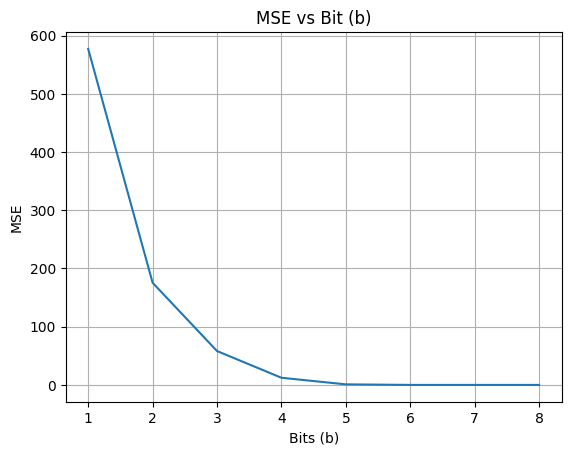

In [33]:
max_lloyd_mse_values = []
# create uniform quantization decision levels
for b in bit_budgets:
    decision_levels, _ = calculate_uniform_quantization_levels_per_bit(img_arr, b)
    decision_levels, repr_levels, mse = run_max_lloyd(hist, decision_levels)
    max_lloyd_mse_values.append(mse)

# plot mse vs. num of bits
print(bit_budgets)
plt.plot(bit_budgets, max_lloyd_mse_values)
plt.title('MSE vs Bit (b)')
plt.xlabel('Bits (b)')
plt.ylabel('MSE')
plt.xticks(bit_budgets)
plt.grid(True)

Plot Decision & Representation Levels - 4b

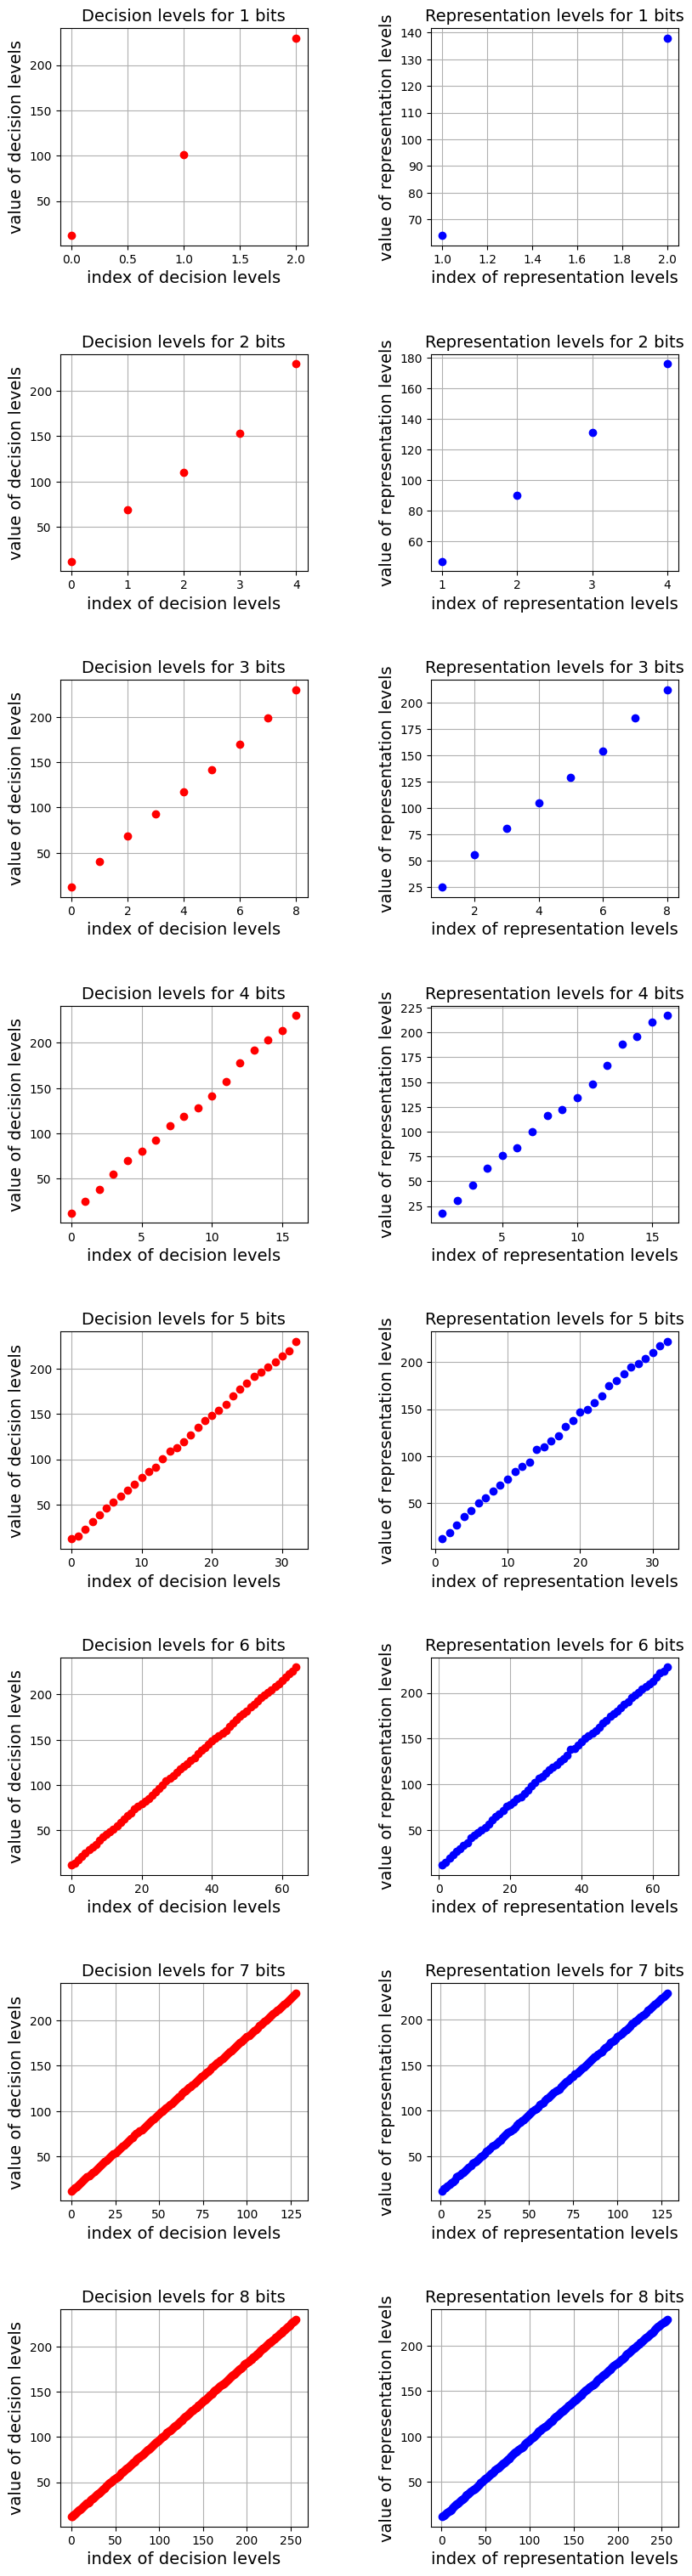

In [34]:
fig, ax = plt.subplots(8, 2, figsize=(8, 30))
plt.tight_layout()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for b in bit_budgets:
    # calculate decision and representation levels for each bit limitation
    decision_levels, _ = calculate_uniform_quantization_levels_per_bit(img_arr, b)

    # run max-lloyd and calculate new representation and decision levels
    decision_levels, repr_levels, _ = run_max_lloyd(hist, decision_levels)

    # plot the decision levels
    ax[b-1,0].plot(range(0,(2**b)+1), decision_levels, "ro")
    ax[b-1,0].set_title("Decision levels for " + str(b) + " bits" , fontsize = 14)
    ax[b-1,0].set_xlabel("index of decision levels", fontsize = 14)
    ax[b-1,0].set_ylabel("value of decision levels", fontsize = 14)
    ax[b-1,0].grid()
    # ax.show()

    #plot representation levels:
    ax[b-1,1].plot(range(1,(2**b)+1), repr_levels, "bo")
    ax[b-1,1].set_title("Representation levels for " + str(b) + " bits", fontsize = 14)
    ax[b-1,1].set_xlabel("index of representation levels", fontsize = 14)
    ax[b-1,1].set_ylabel("value of representation levels", fontsize = 14)
    ax[b-1,1].grid()

Section 2 - Subsampling & Reconstruction
1a = MSE Sampling

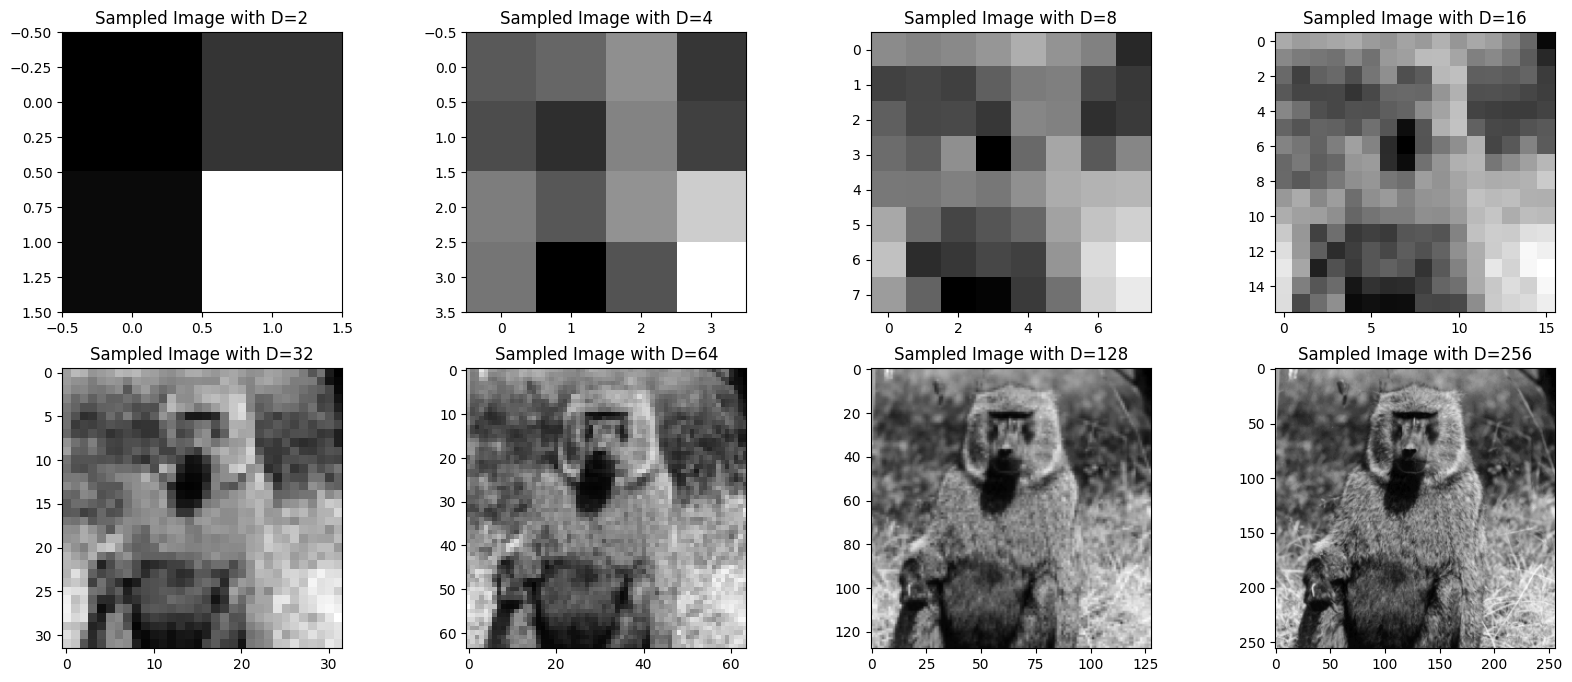

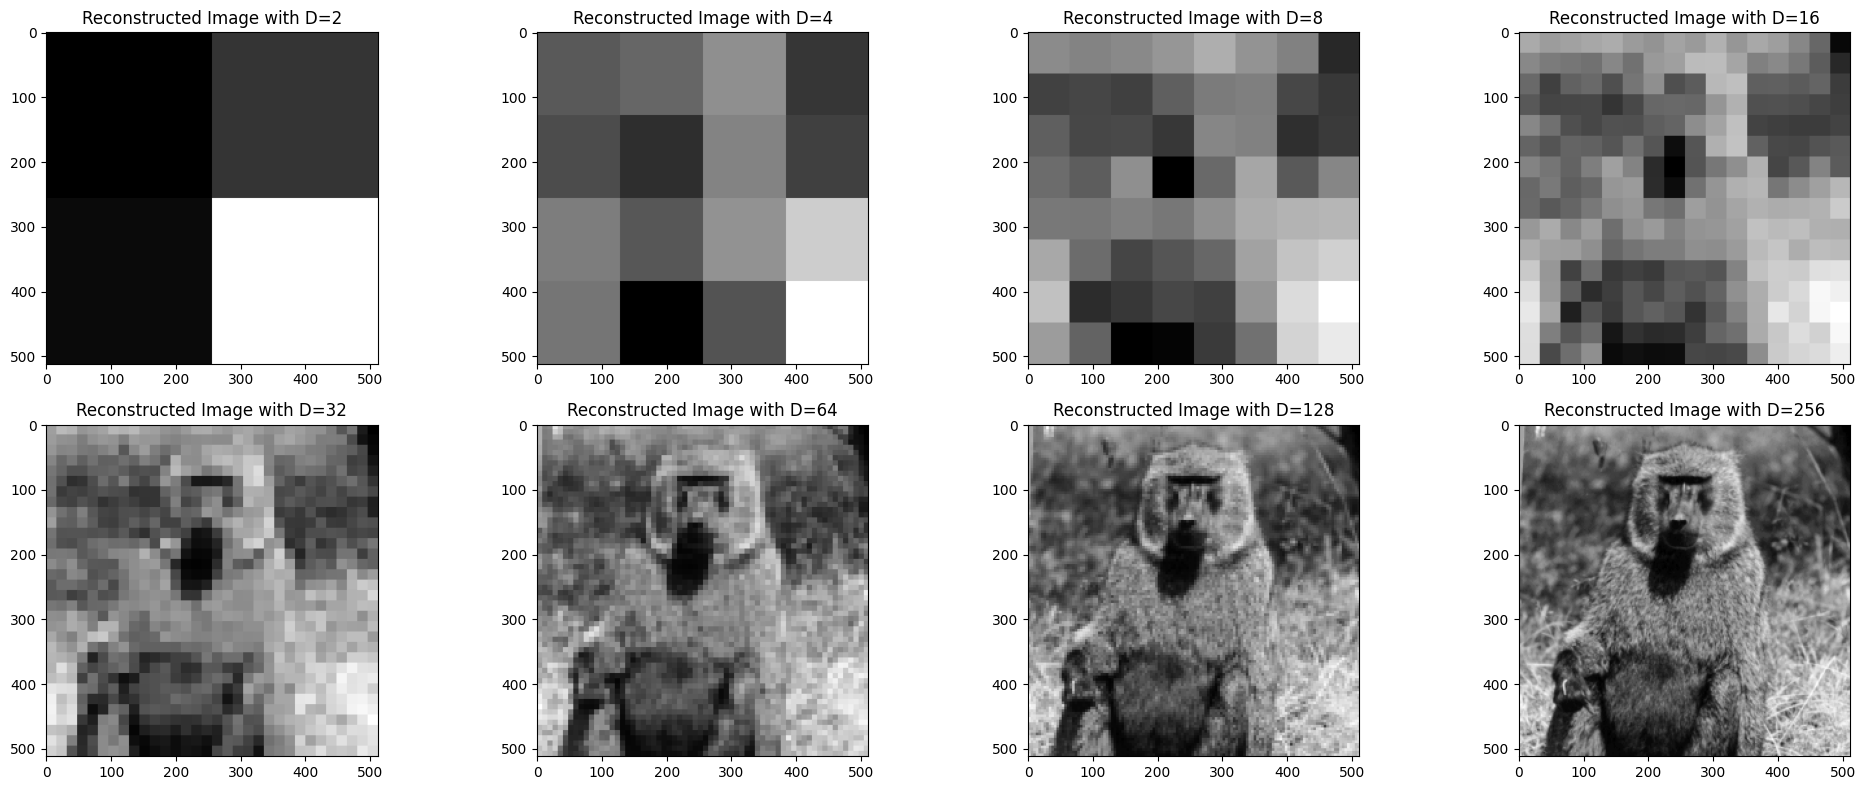

In [53]:
d_values = [2**i for i in range(1,9)]
curr_img = img_arr.reshape(512,512)

def subsample_image_by_factor_mse(img, factor):
    new_img = np.zeros((factor, factor))
    window_size = img.shape[0] // factor
    for i in range(factor):
        for j in range(factor):
            curr_area = img[i*window_size:(i+1)*window_size,j*window_size:(j+1)*window_size]
            new_img[i][j] = np.mean(curr_area)
    # mse = np.mean((new_img - img)**2)
    return new_img

def reconstruct_image(sampled_img, orig_img_shape):
    new_img = np.zeros((orig_img_shape, orig_img_shape))
    factor = orig_img_shape//sampled_img.shape[0]
    for i in range(sampled_img.shape[0]):
        for j in range(sampled_img.shape[0]):
            new_img[i*factor:(i+1)*factor,j*factor:(j+1)*factor]= sampled_img[i][j]
    return new_img

sampled_images = []
reco_images = []
sampled_mse_values = []
for d in d_values:
    sampled_img = subsample_image_by_factor_mse(curr_img, d)
    reco_image = reconstruct_image(sampled_img, curr_img.shape[0])
    sampled_mse_values.append(np.mean((reco_image - curr_img)**2))
    sampled_images.append(sampled_img.copy())
    reco_images.append(reco_image.copy())

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig_rec, axes_rec = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()
axes_rec = axes_rec.flatten()

for i, ax in enumerate(axes):
    ax.imshow(sampled_images[i], cmap="grey")
    ax.set_title(f"Sampled Image with D={d_values[i]}")


for i, ax in enumerate(axes_rec):
    ax.imshow(reco_images[i], cmap="grey")
    ax.set_title(f"Reconstructed Image with D={d_values[i]}")

plt.tight_layout()


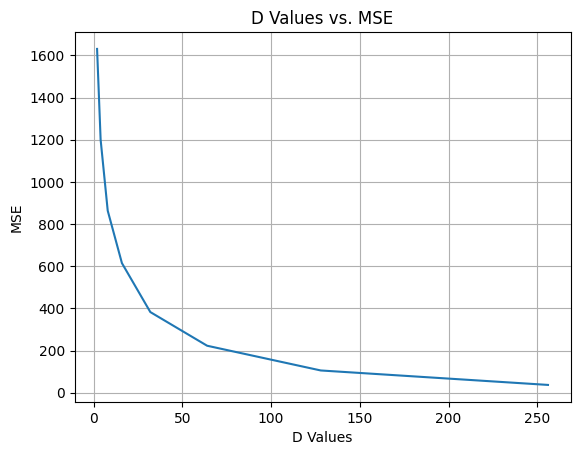

In [36]:
# show the mse_values vs d_values
plt.plot(d_values, sampled_mse_values)
plt.title('D Values vs. MSE')
plt.xlabel('D Values')
plt.ylabel('MSE')
plt.grid(True)

1b - MAD Sampling

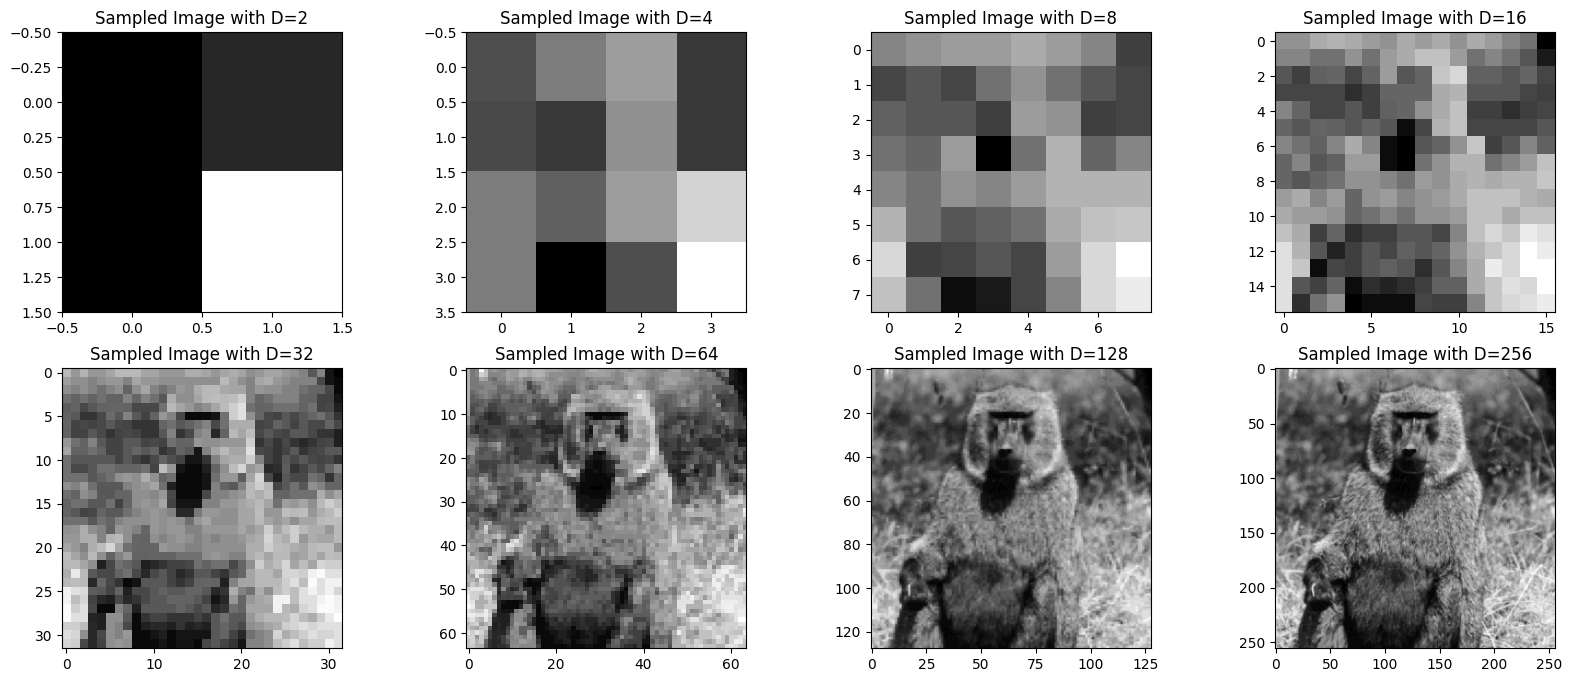

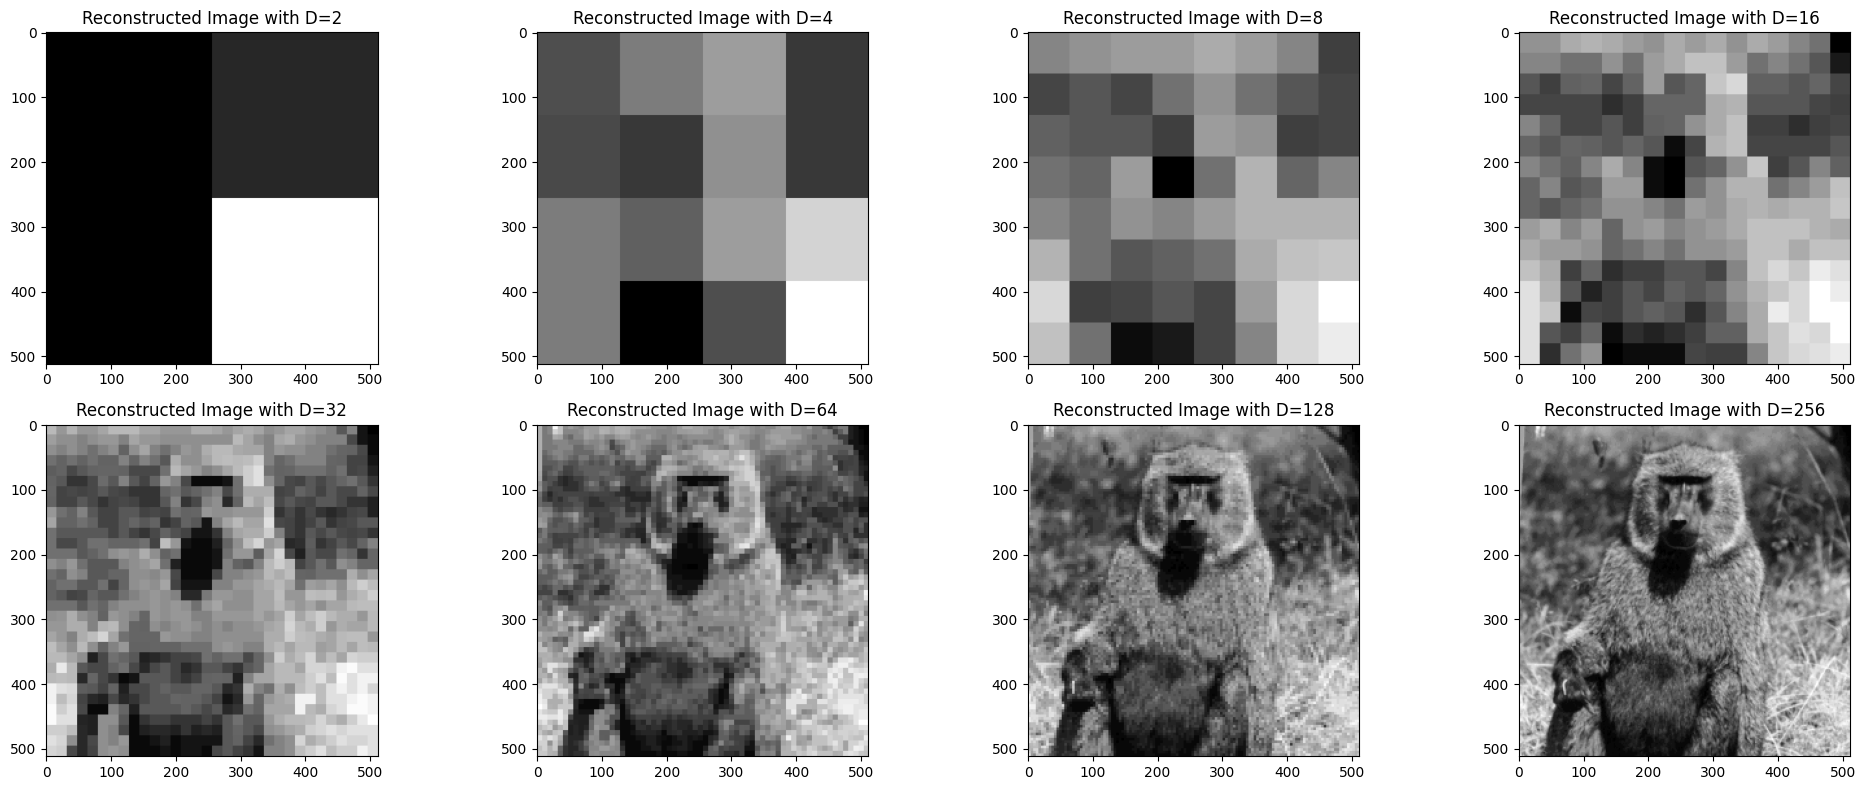

In [52]:
def subsample_image_by_factor_mad(img, factor):
    new_img = np.zeros((factor, factor))
    window_size = img.shape[0] // factor
    for i in range(factor):
        for j in range(factor):
            curr_area = img[i*window_size:(i+1)*window_size,j*window_size:(j+1)*window_size]
            new_img[i,j] = np.median(curr_area)
    return new_img

sampled_images = []
sampled_mad_values = []
reco_images = []
for d in d_values:
    sampled_img = subsample_image_by_factor_mad(curr_img, d)
    reco_image = reconstruct_image(sampled_img, curr_img.shape[0])

    sampled_mad_values.append(np.mean(np.abs(reco_image - curr_img)))
    sampled_images.append(sampled_img.copy())
    reco_images.append(reco_image.copy())

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig_rec, axes_rec = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()
axes_rec = axes_rec.flatten()

for i, ax in enumerate(axes):
    ax.imshow(sampled_images[i], cmap="grey")
    ax.set_title(f"Sampled Image with D={d_values[i]}")


for i, ax in enumerate(axes_rec):
    ax.imshow(reco_images[i], cmap="grey")
    ax.set_title(f"Reconstructed Image with D={d_values[i]}")

plt.tight_layout()


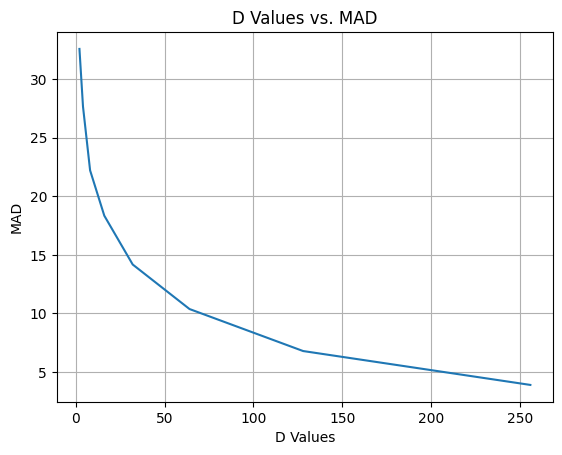

In [38]:
# show the mse_values vs d_values
plt.plot(d_values, sampled_mad_values)
plt.title('D Values vs. MAD')
plt.xlabel('D Values')
plt.ylabel('MAD')
plt.grid(True)

Section 3 - Solving Lp using L2
Question 1

(-0.5, 63.5, 63.5, -0.5)

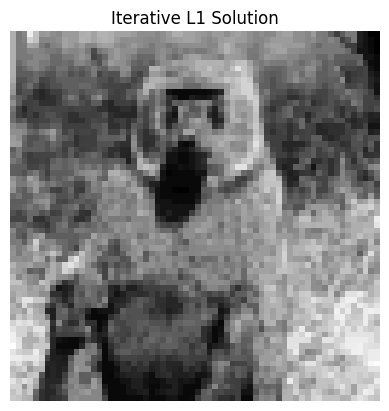

In [63]:
def solve_iterative_lp_problem(img, N, p, epsilon, delta=1e-2):
    window_size = img.shape[0] // N
    result_img = np.zeros((N,N))
    curr_lp_error =  np.mean((img)**p)
    iteration = 0
    while iteration < 100:
        next_error = 0
        for i in range(N):
            for j in range(N):
                curr_window = img[i * window_size:(i+1)*window_size,j*window_size:(j+1)*window_size]
                # calculate new weights
                diff = np.abs(curr_window - result_img[i][j])
                # only power not zero values
                not_zero_indicies = diff != 0
                diff[not_zero_indicies] = diff[not_zero_indicies] ** (p-2)
                new_weights = np.minimum(diff, 1 / epsilon)
                # multiplying function by the weights
                weighted_function = curr_window * new_weights
                # calculate weighted mean (weighted L2 solution)
                if np.sum(new_weights) == 0:
                    continue
                result_img[i][j] = np.sum(weighted_function) / np.sum(new_weights)
                next_error += np.sum(np.abs(curr_window - result_img[i][j])**p)
        iteration +=1
        next_error = next_error / img.size

        # check if the change in error is small enough
        if np.abs(next_error - curr_lp_error) < delta:
            break
        # assign new error
        curr_lp_error = next_error
    return result_img, curr_lp_error

result_img, error = solve_iterative_lp_problem(curr_img, 64, 1, 1e-5)
plt.imshow(result_img, cmap='grey')
plt.title('Iterative L1 Solution')
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

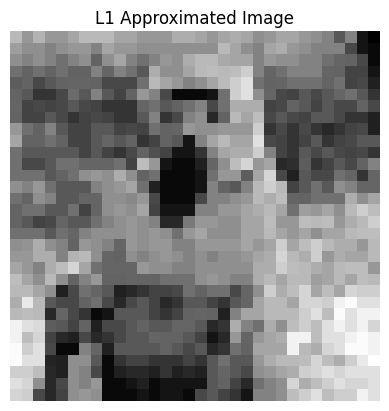

In [40]:
# L1 Approximation
def solve_l1_problem(img, N):
  result_img = np.zeros((N,N), dtype=np.float64)
  window_size = img.shape[0]//N
  error = 0
  for i in range(N):
    for j in range(N):
      curr_window = img[i*window_size:(i+1)*window_size,j*window_size:(j+1)*window_size]
      result_img[i][j] = np.median(curr_window)
      error += np.sum(np.abs(curr_window - result_img[i][j]))
  return result_img, error/img.size

result_img, error = solve_l1_problem(curr_img, 32)
plt.imshow(result_img, cmap='grey')
plt.title('L1 Approximated Image')
plt.axis('off')

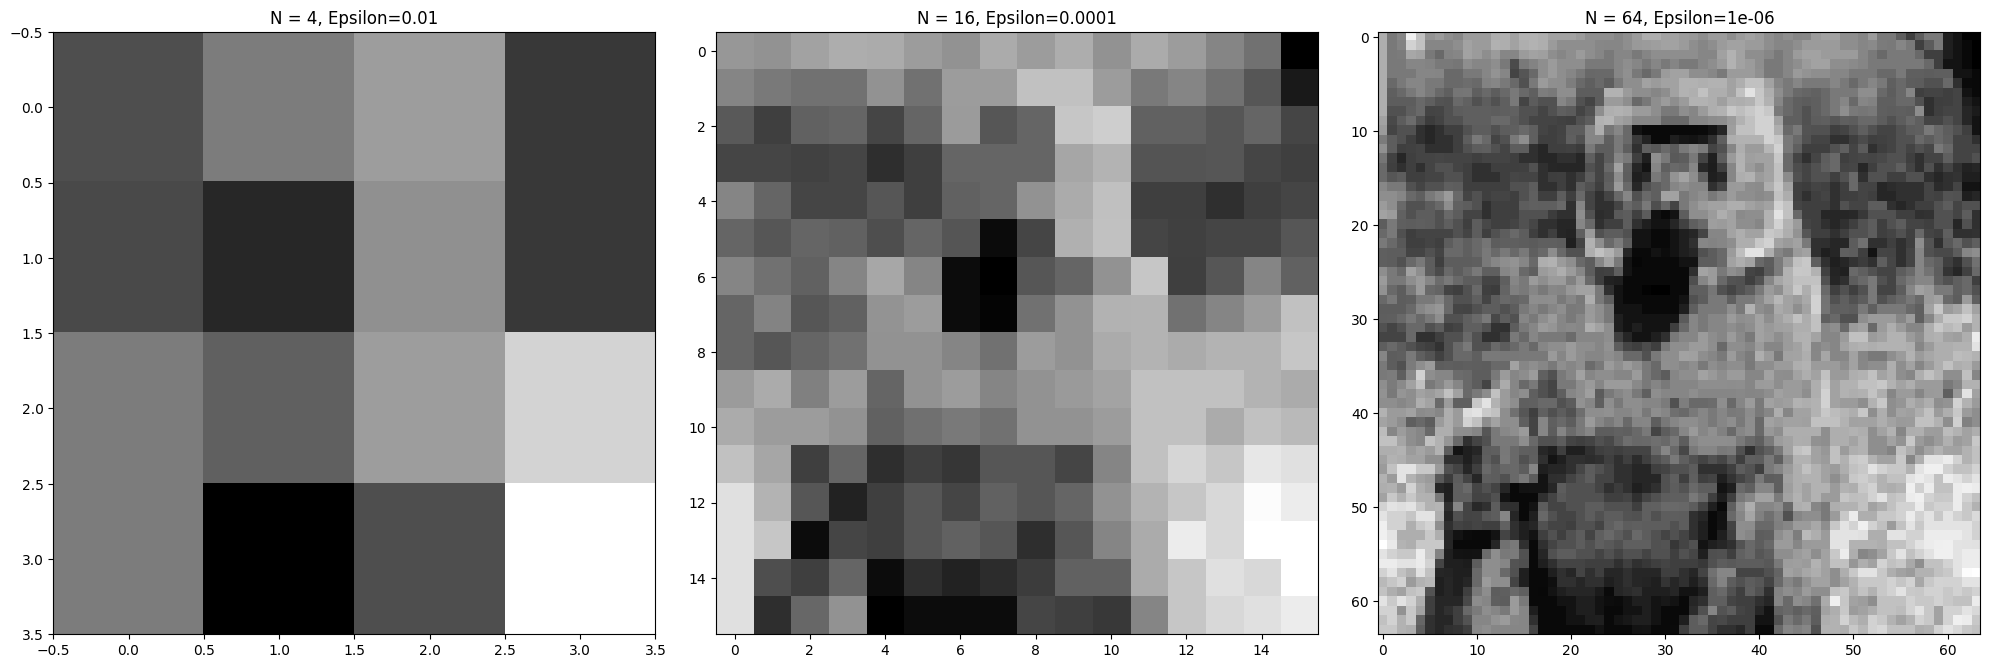

In [41]:
# Comparison between the algorithms
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
plt.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.1)


Lp_errors_array=np.zeros((8,6))
L1_optimal_errors=np.zeros(8)
N_values = [2**x for x in range(1,9)]
epsilon_values = [10**x for x in range(-1,-7,-1)]
approx_images = []
k = 0
for i, N in enumerate(N_values):
  for j, epsilon in enumerate(epsilon_values):
    approx_img, L1_approx_error_i_j = solve_iterative_lp_problem(curr_img, N, p=1, epsilon=epsilon, delta=0.001)
    Lp_errors_array[i][j] = L1_approx_error_i_j
    if ((i==1 and j==1) or (i==3 and j==3) or (i==5 and j==5)):
      approx_images.append((approx_img, N, epsilon))
      #printing choice sampled images
      k += 1
  quantized_image, L1_optimal_error = solve_l1_problem(curr_img,N)
  L1_optimal_errors[i] = L1_optimal_error
axes = axes.flatten()

for i, ax in enumerate(axes):
    app_img, N, epsilon = approx_images[i]
    ax.imshow(app_img, cmap="grey")
    ax.set_title(f"N = {N}, Epsilon={epsilon}")


In [42]:
import pandas as pd
Lp_errors_df = pd.DataFrame(Lp_errors_array, columns=epsilon_values, index=N_values)
Lp_errors_df

,0.100000,0.010000,0.001000,0.000100,0.000010,0.000001
2,32.612504,32.611433,32.592300,32.592298,32.592298,32.592298
4,27.670369,27.668671,27.668584,27.668578,27.668578,27.668578
8,22.221497,22.219663,22.219555,22.219545,22.219544,22.219544
16,18.352889,18.349977,18.349786,18.349768,18.349767,18.349766
32,14.184148,14.180687,14.180429,14.180405,14.180403,14.180403
64,10.381186,10.377329,10.376994,10.376964,10.376961,10.376961
128,6.789261,6.784467,6.784071,6.784038,6.784035,6.784035
256,3.892122,3.887910,3.887859,3.887859,3.887859,3.887859


In [60]:

pd.DataFrame(np.array(L1_optimal_errors), index=N_values)

,0
2,32.581287
4,27.658672
8,22.209179
16,18.339390
32,14.169941
64,10.367817
128,6.780514
256,3.887264


L4 Vs. L3/2

In [44]:
l4_img, l4_error = solve_iterative_lp_problem(curr_img, N=2**5 ,p=4 ,epsilon=0.00001 ,delta=0.001)
l3_2_img, l3_2_error = solve_iterative_lp_problem(curr_img, N=2**5 ,p=1.5 ,epsilon=0.00001 ,delta=0.001)

Text(0.5, 1.0, 'sampled L4 image')

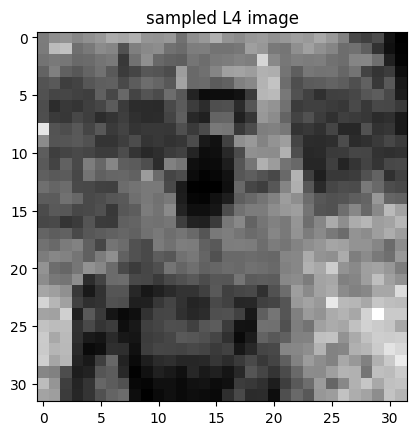

In [62]:
plt.imshow(l4_img, cmap='gray')
plt.title("sampled L4 image")

Text(0.5, 1.0, 'sampled L3/2 image')

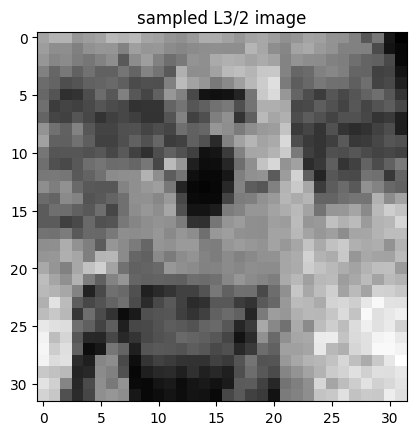

In [61]:
plt.imshow(l3_2_img, cmap='gray')
plt.title("sampled L3/2 image")